In [1]:
%pylab inline
%config InlineBackend.figure_format = 'retina'
%pip install torchmetrics


Populating the interactive namespace from numpy and matplotlib
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 517.2/517.2 KB 5.5 MB/s eta 0:00:00


In [2]:
import torch
from torch import nn
import torch.nn.functional as F
import torchvision
from torchmetrics import Accuracy
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import os
import gc

V = lambda x: x.detach().cpu().numpy()

if not os.path.exists('figures'):
    os.mkdir('figures')
if not os.path.exists('figures/ensemble'):
    os.mkdir('figures/ensemble')

torch.__version__

'1.13.1+cu116'

In [3]:
class Trainer:
    def __init__(self, model, dataset, device = 'cpu'):
        # val_data = dataset.data[-n_val:]
        # val_targets = dataset.targets[-n_val:]
        self.device = device
        self.model = model.to(device)
        self.dataset = dataset
        self.dataset.data = self.dataset.data.to(device)
        self.dataset.targets = self.dataset.targets.to(device)
        self.optim = torch.optim.Adam(self.model.parameters())
        self.history = {'train_loss': [], 'train_acc':[], 'val_loss':[], 'val_acc':[]}
        self.accuracy = Accuracy(task='multiclass', num_classes=len(self.dataset.classes)).to(device)
        
    def fit(self, epochs =1, batch_size = 32, val_split=0.2, val_num = 1000, verbose=True):
        n = len(self.dataset.data)
        n_val = int(val_split*n)
        n_train = n-n_val 
        
        for ep in range(epochs):
            total_loss = []
            acc_acc = []
            for i in range(0,n_train, batch_size):
                x,y = self.dataset.batch_get(i,i+batch_size)

                self.optim.zero_grad()
                y_pred = self.model(x)
                loss = F.cross_entropy(y_pred, y)
                loss.backward()
                total_loss += [loss.item()+0]
                acc = self.accuracy(y_pred,y)
                acc_acc += [acc.item()+0]
                self.optim.step()
                if i % 20*batch_size and verbose:
                    print(f'{ep} Train: {i/n_train*100:.0f}\t loss: {loss:.3g},\t acc:{acc:.3f}', end='\r')
            self.history['train_loss'] += [mean(total_loss)]
            self.history['train_acc'] += [mean(acc_acc)]
            x,y = self.dataset.batch_get(-min(n_val, val_num), n)
            y_pred = self.model(x)
            loss = F.cross_entropy(y_pred, y)
            acc = self.accuracy(y_pred,y)
            if verbose:
                print(f'\n  Test:  \t loss: {loss:.3g},\t acc:{acc:.3f}')
            self.history['val_loss'] += [loss.item()+0]
            self.history['val_acc'] += [acc.item()+0]
        

# Group Action Activation layer
This layer implements the symmetry group action 
$$ U\sigma(H) \to U\pi(g,H)\sigma(gH) $$
by wrapping it around an activation function $\sigma' (x) = \pi(g,x)\sigma(gx) $, so that $U\sigma'(H) =  U\pi(g,H)\sigma(gH)$. 

In [4]:
from pickle import FALSE
import warnings

class GroupActivation(nn.Module):
    def __init__(self, in_features, nonlinearity = nn.Identity(), num_g = 1, eps = 1, T=None):
        """Replaces a nonlinear activation layer. 
        In normal mode, self(x) = nonlinearity(x)
        
        Args:
        in_features: # features of input; expects input of shape (batch, in_features, ...)
        num_g: number of group elements to use transform output
        eps: used in `g=exp(eps*T)` where `T` are gl_h Lie algebra elements. 
        T: if None, random T (of Lie algebra) will be created. If provided, with shape (num_g,h,h) 
            they will be used for computing g.   
        
        Flags:
        self.UPDATE_MODE: = False. If True, during forward pass, `num_g` batches of data
            will be stored as self.H for computing group rep $\pi(g,H) = \sigma(H)\sigma(gH)^+$. 
            self.H batch sizes are capped to in_features, as required for $pi(g,H)$.  
        self.G_ACT_MODE: = False. If True, uses group in forward pass 
            return size : batch_size,... -> num_g*batch_size,... 
        """
        super().__init__()
        self.in_features = in_features
        self.nonlinearity = nonlinearity
        self.num_g = num_g 
        self.eps = eps
        # in UPDATE_MODE, 
        self.UPDATE_MODE = False
        self.G_ACT_MODE_RANDOM = False # if True, uses random transform in forward pass 
        self.G_ACT_MODE_RANDOM_PERMUTE = False
        self.G_ACT_MODE_RANDOM_g = False
        self.PERMUTE_INTER = False
        self.invert_g_computed = False
        

        self.G_ACT_MODE = False # if True, uses group in forward pass 
        # in G-act mode: (batch_size -> num_g*batch_size)
        # self._G_INIT = False # set first time self.g is initialized 
        self.init_G(T)
        self.H = None
        
    def group_act_lower(self,H):
        """ input H -> gH """
        return torch.einsum('ncd...,bc...->nbd...', self.g, H)
    
    def batch_g_act(self,g,H):
        """input and output shape (num_g, batch, chan_out, ...)"""
        # return torch.einsum('ndc...,nbc...->nbd...', g, H)
        return torch.einsum('ncd...,nbc...->nbd...', g, H)
    
    def group_act_upper(self,sigma_gH):
        """ sigma(gH) -> pi(g,H0)*sigma(gH) 
        H0: batch used for computing pi(g,H0)
        H : new input 
        input and output shape (num_g, batch, chan_out, ...)
        """
        if self.G_ACT_MODE_RANDOM:
            I_diag = torch.ones(self.pi_g_H.size()[0], self.pi_g_H.size()[1])
            I = torch.diag_embed(I_diag)
            M = torch.rand_like(I)
            rand_M = I + self.eps * M
            rand_M = rand_M.to(DEVICE)
            return self.batch_g_act(rand_M, sigma_gH)
        elif self.G_ACT_MODE_RANDOM_PERMUTE:
            r = torch.randperm(self.pi_g_H.size()[0])
            c = torch.randperm(self.pi_g_H.size()[1])
            rand_pi_g_H = self.pi_g_H[r][:,c]
            r = torch.randperm(self.pi_g_H.size()[0])
            c = torch.randperm(self.pi_g_H.size()[1])
            rand_pi_g_H = rand_pi_g_H[r][:,c]
            rand_pi_g_H = rand_pi_g_H.to(DEVICE)
            return self.batch_g_act(rand_pi_g_H, sigma_gH)
        elif self.G_ACT_MODE_RANDOM_g:
            if not self.invert_g_computed:
                self.g_inv = torch.linalg.pinv(self.g)
                self.invert_g_computed = True
            return self.batch_g_act(self.g_inv, sigma_gH)
        else:
            return self.batch_g_act(self.pi_g_H, sigma_gH)
    
    
    def get_group_rep_upper(self,):
        """Compute $\pi(g,H) = \sigma(H) \sigma(gH)^+$ 
        Because the batch index is first (instead of last in our theory)
        we actually need `pi(g,H) = pinv(sigma(gH)) @ sigma(H)`. 
        We use torch.linalg.lstsq(A,B) = A.pinverse() @ B 
        (supposedly more numerically stable than pinverse). 
        """
        # to use lstsq, batch, channel must be last two dims
        # to (num_g, ..., batch, cin)  
        H_perm = self.H.permute(0,*torch.arange(3,self.H.ndim),1,2)
        H_perm = self.nonlinearity(H_perm)
        
        # stored H are (num_g, batch, cin, ...); regular H is (batch, cin,...)
        gH = self.batch_g_act(self.g, self.H)
        # to (num_g, ..., batch, channel)  
        gH_perm = gH.permute(0,*torch.arange(3,gH.ndim),1,2)
        gH_perm = self.nonlinearity(gH_perm)
        
        self.pi_g_H = torch.linalg.lstsq(gH_perm, H_perm).solution
        # move the (in,out) indices of g first
        # shape (num_g, cin, cin, ...)
        self.pi_g_H = self.pi_g_H.permute(0,-2,-1,*torch.arange(1, self.pi_g_H.ndim-2))
                
    def store_batch(self,H, noise=1e-4):
        """stores a queue of H of size num_g. 
        Note: because we need in_features >= batch, the batch size is capped to in_features.
        """
        H_capped = H[:self.in_features]
        
        if not hasattr(self,'_H_counter'):
            # initialize 
            self._H_counter = 0
            self.H = noise*torch.randn(self.num_g, *H_capped.shape).to(H_capped.device)
        
        self.H[self._H_counter] += H_capped
        # print(f'H batch {self._H_counter}/{self.num_g} stored')
        self._H_counter = (self._H_counter + 1) % self.num_g 
        
    def update_g(self,H):
        self.store_batch(H)
        if self._H_counter == 0:
            warnings.warn("Suffiecient H stored. Computing pi(g,H). "
                          "Consider setting self.UPDATE_MODE = False")
            self.get_group_rep_upper() 
        
    def forward(self, H):
        if self.UPDATE_MODE:
            # store batches 
            self.update_g(H)
            
        if not self.G_ACT_MODE: 
            return self.nonlinearity(H)
        elif self.PERMUTE_INTER:
            # [0.5(I+g)]^{-1} \sigma [0.5(I+g) H]
            # g = (I+ eps*0.5*(I+perm))/(1+eps)
            n = self.g.size()[0]
            h = H.size()[1]
            g = torch.zeros_like(self.g)
            g_inv = torch.zeros_like(self.g)

            for i in range(n):
                perm = torch.argsort(torch.rand(h))
                perm_inv = torch.argsort(perm)
                I = torch.eye(h)
                g[i] = (I + 0.5 * self.eps * (I + I[perm])) / (1 + self.eps)
                g_inv[i] = torch.linalg.pinv(g[i])
            gH = torch.einsum('ncd...,bc...->nbd...', g, H)
            gH = self.nonlinearity(gH)
            gH = torch.einsum('ncd...,nbc...->nbd...', g_inv, gH)
            return gH.flatten(start_dim=0, end_dim=1)
        else:
            gH = self.group_act_lower(H)
            gH = self.nonlinearity(gH)
            gH = self.group_act_upper(gH)
            # combine num_g and batch 
            return gH.flatten(start_dim=0, end_dim=1)
    
    def transform_U(self,):
        """ upper weight U -> g U = U pi(g,H) """
        pass 
    
    def init_G(self,T=None):
        self.T = T
        cin = self.in_features #self.H.shape[2] #(num_g, batch, cin, ...)
        
        if type(self.T) == type(None):
            if self.num_g > 0:
                self.T = torch.randn(self.num_g, cin, cin) / cin**.5
            else:
                self.T = torch.zeros(1,  cin, cin)
            
        else:
            assert type(self.T)==torch.Tensor
            self.num_g = len(self.T)
            
        # self.g = torch.eye(cin) + self.eps * self.T   
        self.g = torch.linalg.matrix_exp(self.eps * self.T)
        # self.g = torch.rand(self.num_g,cin,cin)
        self.T = nn.Parameter(self.T)
        self.g = nn.Parameter(self.g)
        
        self.T.requires_grad = False
        self.g.requires_grad = False
        

# cifar10

In [5]:
DEVICE = 'cuda'

In [6]:
# cifar10 = torchvision.datasets.CIFAR10('../data/',download=False)
# the data from CIFAR10 class is in PIL format and needs processing before we can use it in a pytorch model

class CIFAR10(torchvision.datasets.CIFAR10):
    def __init__(self, device='cpu', **kws):
        super().__init__(**kws)
        self.data = torch.tensor(self.data.transpose(0,3,1,2)/255. - 0.5, dtype=torch.float32).to(device)
        self.targets = torch.tensor(self.targets, dtype = torch.long).to(device)

    def __getitem__(self,i):
        return (self.data[i], self.targets[i])
    
    def batch_get(self,i,j):
        return (self.data[i:j], self.targets[i:j])

    
cif2= CIFAR10(root='../data/', download=True, device=DEVICE)
cif2_test = CIFAR10(root='../data/', train=False, device=DEVICE)
len(cif2_test.data), len(cif2.data)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ../data/cifar-10-python.tar.gz to ../data/


(10000, 50000)

In [7]:
m = nn.LeakyReLU(0.1)
def relu_sqr(x):
    return m(x) * m(x) + 1e-2 * x

In [8]:
h_list = [32] #[4, 8, 16, 32, 64]
num_g_list = [10, 20, 40, 60, 80, 100, 120]
eps_list = [2e1, 1e1, 1e0, 1e-1, 1e-2, 1e-3, 1e-4]

acc_original = np.zeros((len(h_list), len(num_g_list), len(eps_list)))
acc_group = np.zeros((len(h_list), len(num_g_list), len(eps_list)))
acc_random = np.zeros((len(h_list), len(num_g_list), len(eps_list)))
acc_random_permute = np.zeros((len(h_list), len(num_g_list), len(eps_list)))
acc_random_g = np.zeros((len(h_list), len(num_g_list), len(eps_list)))
acc_random_inter = np.zeros((len(h_list), len(num_g_list), len(eps_list)))
val_loss_original = np.zeros((len(h_list), len(num_g_list), len(eps_list)))
val_loss_group = np.zeros((len(h_list), len(num_g_list), len(eps_list)))
val_loss_random = np.zeros((len(h_list), len(num_g_list), len(eps_list)))
val_loss_random_permute = np.zeros((len(h_list), len(num_g_list), len(eps_list)))
val_loss_random_g = np.zeros((len(h_list), len(num_g_list), len(eps_list)))
val_loss_random_inter = np.zeros((len(h_list), len(num_g_list), len(eps_list)))

In [9]:
#im-size 
p = 32
cin = 3
nf = 32

h_list = [16] #[4, 8, 16, 32, 64]
num_g_list = [10, 20, 40, 60, 80, 100, 120]
eps_list = [2e1, 1e1, 1e0, 1e-1, 1e-2, 1e-3, 1e-4]

for h_idx, h in enumerate(h_list):
    for num_g_idx, num_g in enumerate(num_g_list): #[(6, 120)]: #, (6, 120) (2, 1e0), 
        for eps_idx, eps in enumerate(eps_list): #[(0, 2e1), (1, 1e1), (2, 1e0), (3, 1e-1), (4, 1e-3), (5, 1e-3), (6, 1e-4)]:
            ga = GroupActivation(h, num_g=num_g, nonlinearity=relu_sqr, eps=eps)

            model = nn.Sequential(
                nn.Conv2d(cin,nf,3, padding='same'),
                nn.LeakyReLU(),
                nn.MaxPool2d(2,2),
                nn.Flatten(),
                nn.Linear((p//2)**2*nf, h),
                ga,
                nn.Linear(h,10),
                nn.Softmax(1),
            ).to(DEVICE)
            model.trainer = Trainer(model, cif2, device = DEVICE)
            model.trainer.fit(10, verbose=False)
            
            # group
            ga.UPDATE_MODE = True
            ga.G_ACT_MODE = False

            x,y = cif2.batch_get(-ga.in_features*ga.num_g, len(cif2.data))
            h = ga.in_features
            for i in range(ga.num_g):
                yp = model(x[i*h:(i+1)*h])
                
            last = -ga.in_features*ga.num_g
            num = 1000
            x,y = cif2.batch_get(-num+last,last)

            ga.UPDATE_MODE = False
            ga.G_ACT_MODE = False
            ga.G_ACT_MODE_RANDOM = False
            y_pred = model(x)

            ga.G_ACT_MODE = True
            y_group = model(x)

            ga.G_ACT_MODE_RANDOM = True
            ga.G_ACT_MODE_RANDOM_PERMUTE = False
            ga.G_ACT_MODE_RANDOM_g = False
            y_random = model(x)

            ga.G_ACT_MODE_RANDOM = False
            ga.G_ACT_MODE_RANDOM_PERMUTE = True
            ga.G_ACT_MODE_RANDOM_g = False
            y_random_permute = model(x)

            ga.G_ACT_MODE_RANDOM = False
            ga.G_ACT_MODE_RANDOM_PERMUTE = False
            ga.G_ACT_MODE_RANDOM_g = True
            y_random_g = model(x)

            ga.G_ACT_MODE_RANDOM_g = False
            ga.PERMUTE_INTER = True
            y_random_inter = model(x)

            accuracy = model.trainer.accuracy
            y_group = y_group.reshape(ga.num_g, *y_pred.shape )
            y_random = y_random.reshape(ga.num_g, *y_pred.shape )
            y_random_permute = y_random_permute.reshape(ga.num_g, *y_pred.shape )
            y_random_g = y_random_g.reshape(ga.num_g, *y_pred.shape )
            y_random_inter = y_random_inter.reshape(ga.num_g, *y_pred.shape )

            val_loss_original[h_idx][num_g_idx][eps_idx] = F.cross_entropy(y_pred, y).item()
            val_loss_group[h_idx][num_g_idx][eps_idx] = F.cross_entropy(y_group.mean(0), y).item()
            val_loss_random[h_idx][num_g_idx][eps_idx] = F.cross_entropy(y_random.mean(0), y).item()
            val_loss_random_permute[h_idx][num_g_idx][eps_idx] = F.cross_entropy(y_random_permute.mean(0), y).item()
            val_loss_random_g[h_idx][num_g_idx][eps_idx] = F.cross_entropy(y_random_g.mean(0), y).item()
            val_loss_random_inter[h_idx][num_g_idx][eps_idx] = F.cross_entropy(y_random_inter.mean(0), y).item()

            acc_original[h_idx][num_g_idx][eps_idx] = accuracy(y_pred, y)
            acc_group[h_idx][num_g_idx][eps_idx] = torch.mode(y_group.data.max(2)[1], 0).values.eq(y).long().cpu().sum() / y.size()[0]  # accuracy(y_group.mean(0), y)
            acc_random[h_idx][num_g_idx][eps_idx] = torch.mode(y_random.data.max(2)[1], 0).values.eq(y).long().cpu().sum() / y.size()[0]
            acc_random_permute[h_idx][num_g_idx][eps_idx] = torch.mode(y_random_permute.data.max(2)[1], 0).values.eq(y).long().cpu().sum() / y.size()[0]
            acc_random_g[h_idx][num_g_idx][eps_idx] = torch.mode(y_random_g.data.max(2)[1], 0).values.eq(y).long().cpu().sum() / y.size()[0]
            acc_random_inter[h_idx][num_g_idx][eps_idx] = torch.mode(y_random_inter.data.max(2)[1], 0).values.eq(y).long().cpu().sum() / y.size()[0]


            print(f'h={h} num_g={num_g} eps={eps} \
                Accuracy: \toriginal={accuracy(y_pred, y):.3f} \
                \tgroup:{accuracy(y_group.mean(0), y):.3f} \
                \trandom:{accuracy(y_random.mean(0), y):.3f} \
                \trandom_permute:{accuracy(y_random_permute.mean(0), y):.3f} \
                \trandom_g:{accuracy(y_random_g.mean(0), y):.3f} \
                \trandom_inter_g:{accuracy(y_random_inter.mean(0), y):.3f} \
                Validation loss: \toriginal={F.cross_entropy(y_pred, y).item():.6f} \
                \tgroup:{F.cross_entropy(y_group.mean(0), y).item():.6f} \
                \trandom:{F.cross_entropy(y_random.mean(0), y).item():.6f} \
                \trandom_permute:{F.cross_entropy(y_random_permute.mean(0), y).item():.6f} \
                \trandom_g:{F.cross_entropy(y_random_g.mean(0), y).item():.6f} \
                \trandom_inter_g:{F.cross_entropy(y_random_inter.mean(0), y).item():.6f}')



<ipython-input-4-9a0d54ca6e1f>:124: UserWarning: Suffiecient H stored. Computing pi(g,H). Consider setting self.UPDATE_MODE = False
  warnings.warn("Suffiecient H stored. Computing pi(g,H). "


h=16 num_g=10 eps=20.0                 Accuracy: 	original=0.560                 	group:0.189                 	random:0.099                 	random_permute:0.094                 	random_g:0.086                 	random_inter_g:0.228                 Validation loss: 	original=1.894813                 	group:2.270056                 	random:2.321812                 	random_permute:2.301889                 	random_g:2.317745                 	random_inter_g:2.251303
h=16 num_g=10 eps=10.0                 Accuracy: 	original=0.568                 	group:0.219                 	random:0.111                 	random_permute:0.113                 	random_g:0.069                 	random_inter_g:0.283                 Validation loss: 	original=1.889618                 	group:2.257545                 	random:2.309163                 	random_permute:2.311495                 	random_g:2.307151                 	random_inter_g:2.221727
h=16 num_g=10 eps=1.0                 Accuracy: 	original=0.539     

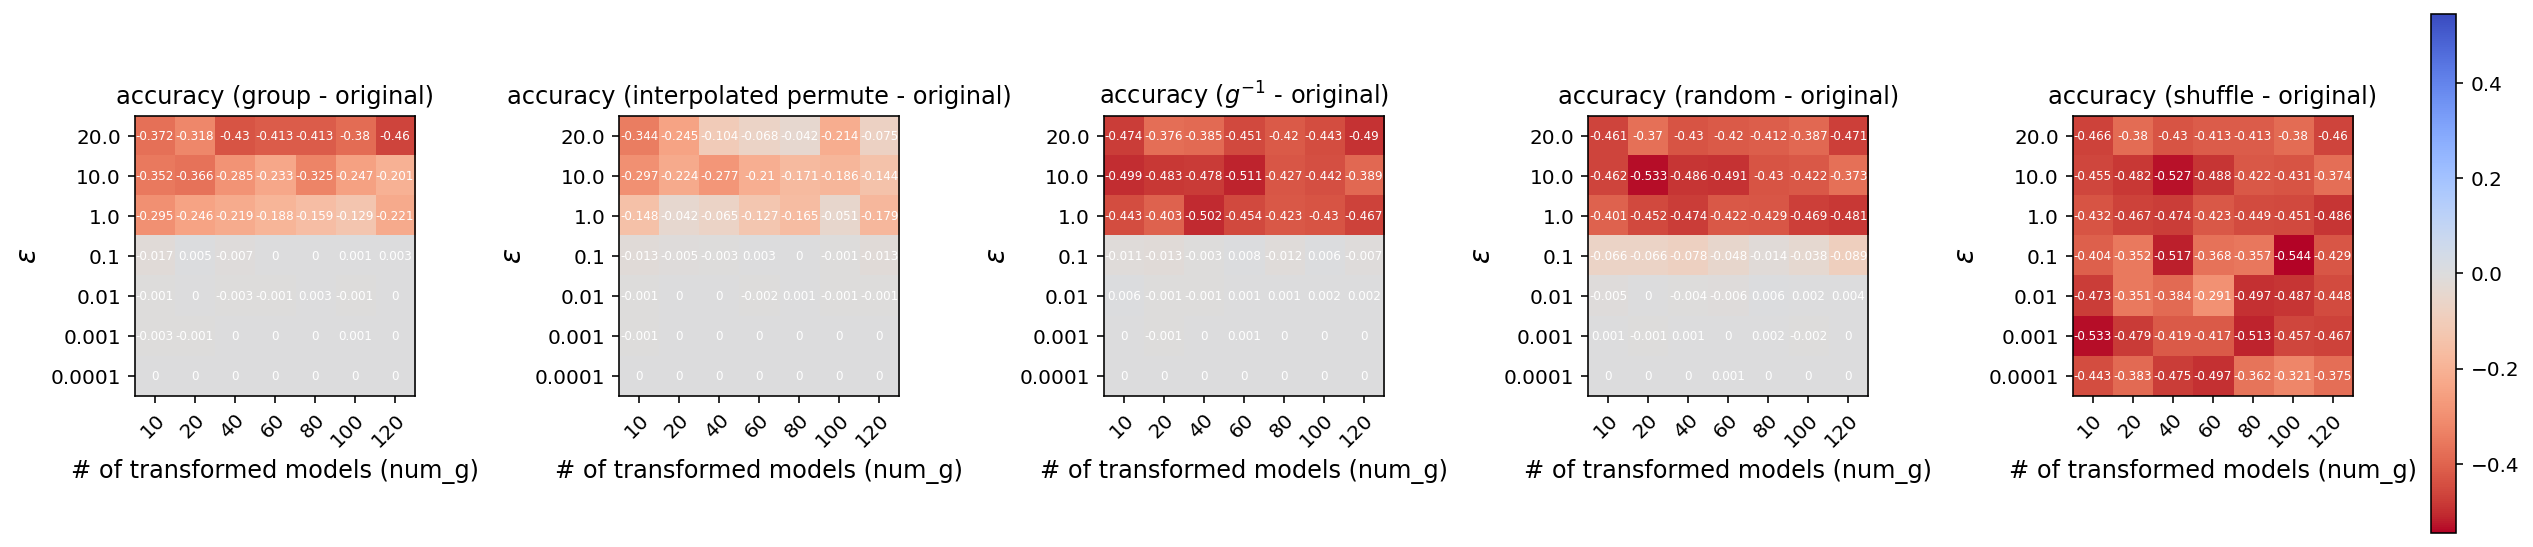

In [10]:
def plot(subplot_idx, acc_diff, vmax, title, cmap='coolwarm_r'):
    acc_diff = np.swapaxes(acc_diff, 0, 1)
    ax = plt.subplot(subplot_idx)
    im = ax.imshow(acc_diff, cmap=cmap, vmax=vmax, vmin=-vmax)

    ax.set_xticks(np.arange(len(num_g_list)))
    ax.set_xticklabels(num_g_list)
    ax.set_yticks(np.arange(len(eps_list)))
    # ax.set_yticklabels(ticker.FormatStrFormatter('%.0e').format_ticks(eps_list))
    ax.set_yticklabels(eps_list)
    ax.set_xlabel('# of transformed models (num_g)',  fontsize=12)
    ax.set_ylabel(r'$\epsilon$', fontsize=14)

    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
            rotation_mode="anchor")

    for num_g_idx in range(len(num_g_list)):
        for eps_idx in range(len(eps_list)):
            text = ax.text(eps_idx, num_g_idx, '{:.3g}'.format(acc_diff[num_g_idx, eps_idx]),
                          ha="center", va="center", color="w", fontsize=6)

    ax.set_title(title)
    return im


fig = plt.figure(figsize=(18,6))
max1 = np.max(abs(acc_group[0] - acc_original[0]))
max2 = np.max(abs(acc_random[0] - acc_original[0]))
max3 = np.max(abs(acc_random_permute[0] - acc_original[0]))
max4 = np.max(abs(acc_random_g[0] - acc_original[0]))
max5 = np.max(abs(acc_random_inter[0] - acc_original[0]))
vmax = np.max([max1, max2, max3, max4, max5])
# print('vmax acc: ', vmax)
plot(151, acc_group[0] - acc_original[0], vmax, 'accuracy (group - original)', cmap='coolwarm_r')
plot(152, acc_random_inter[0] - acc_original[0], vmax, 'accuracy (interpolated permute - original)', cmap='coolwarm_r')
plot(153, acc_random_g[0] - acc_original[0], vmax, 'accuracy (' + r'$g^{-1}$' + ' - original)', cmap='coolwarm_r')
plot(154, acc_random[0] - acc_original[0], vmax, 'accuracy (random - original)', cmap='coolwarm_r')
im = plot(155, acc_random_permute[0] - acc_original[0], vmax, 'accuracy (shuffle - original)', cmap='coolwarm_r')


plt.tight_layout()
fig.subplots_adjust(right=0.91)
cbar_ax = fig.add_axes([0.94, 0.18, 0.01, 0.6])
plt.colorbar(im, cax=cbar_ax)  
plt.savefig('figures/ensemble/cnn_cifar_leakyrelu2_main_acc.pdf')
